# Lab 3: Speech Recognition with Mel-Frequency Cepstral Coefficient and Convolutional Neural Network

In this exercise you will learn an efficient method for processing audio recordings using Mel-frequency cepstral coefficient (MFCC) and a convolutional neural network (CNN).

## MFCC feature extraction and network training

![audio_workflow](audio_workflow.png)

The idea is to segment one slice of a continuous input signal into (overlapping)
segments, do some preprocessing, and stack the resulting processed segments over one-another to
obtain a two-dimensional frame. On these frames the same principles are used as for ”real”
images when it comes to machine learning.

# Download the "Hey Snips" dataset
For this exercise we are going to use the ”Hey Snips” dataset from Couke et al. 2018 ”Efficient
keyword spotting using dilated convolutions and gating”. The train dataset consists of utterances
from 30 speakers, the test dataset consists of utterances from 10 speakers. The length of each
utterance ranges between about 3 and 9 seconds, the data is labeled 1 if the sentence ”Hey Snips!”
was uttered and 0 if not.

Please visit the [Dataset Repository](https://github.com/sonos/keyword-spotting-research-datasets) and fill out the form to proceed with the dataset download. It is roughly 8.4GB.

In [7]:
import json, random
import numpy as np
from scipy.io import wavfile
import tensorflow as tf
from tqdm import tqdm
import os
import zipfile, tempfile
import simpleaudio as sa

DataSetPath = "hey_snips_research_6k_en_train_eval_clean_ter/"

with open(DataSetPath+"train.json") as jsonfile:
    traindata = json.load(jsonfile)

with open(DataSetPath+"test.json") as jsonfile:
    testdata = json.load(jsonfile)

# Load data 
Here we load the data from the "hey_snips" dataset and extract the MFCC features from it. 

This is an example of how a data sample looks like.
Information from the [Dataset Repository](https://github.com/sonos/keyword-spotting-research-datasets).

```
  {
    "id": "40084ea8-c576-4dba-a20b-fbda61f1de7d"
    "is_hotword": 1, 
    "worker_id": 12, 
    "duration": 1.86, 
    "audio_file_path": "audio_files/40084ea8-c576-4dba-a20b-fbda61f1de7d.wav", 
  }
```
- `id:` A unique identifier located in the audio_files subdirectory of the dataset
- `is_hotword:` A 1 if the sample is a hotword and a 0 if not. This is what we are actually after in this classification model. Thus it acts as the label.
- `worker_id:` The unique identifier of the contributor - note that worker ids are not consistent across datasets 1 and 2 as they are re-generated for each one of them.
- `duration:` The duration of the audiofile in seconds.
- `audio_file_path:` The filepath to the respective audio sample.

But now we need to bring it into a format that we can actually learn in our machine learning model. So lets look at how that conversion looks like:



1. We read the .wav file under the `audio_path`, this returns the sample rate (in samples/sec) and data from an LPCM WAV file. For more information see the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html).

2. We zero-stuff the training and test samples so we have a constant slice length. As in the initial image.

3. Now we segment the slices. For simplifying this exercise, we will choose the segment overlap to be 0. We might also want our segments to have a certain length - Powers of 2 will enable us to do faster FFTs.

For time reasons we will also not load all training and test samples, but a smaller subset of them.

## Let's have a look at a single example
Here we perform the previously mentioned preprocessing steps. You will hear a random .wav sample of the test set and see how we aggregate the data and label.

_Turn on your speakers!_

In [8]:
testsize = 100 # Number of loaded testing samples
totalSliceLength = 10 # Length to stuff the signals to, given in seconds

fs = 16000 # Sampling rate of the samples
segmentLength = 1024 # Number of samples to use per segment

sliceLength = int(totalSliceLength * fs / segmentLength)*segmentLength

rand_idx = random.randrange(0, testsize)
fs, test_sound_data = wavfile.read(DataSetPath+testdata[rand_idx]['audio_file_path'])
_x_test = test_sound_data.copy()
_x_test.resize(sliceLength)
_x_test = _x_test.reshape((-1,int(segmentLength)))
_x_test.astype(np.float32)
label = testdata[rand_idx]['is_hotword']

#Play the .wav file
wave_obj = sa.WaveObject.from_wave_file(DataSetPath+testdata[rand_idx]['audio_file_path'])
play_obj = wave_obj.play()
play_obj.wait_done()

print('Data: ', _x_test) #Notice the zero stuffing
print('Label: ', label)

Data:  [[  4  12  25 ...  69  65  59]
 [ 63  65  70 ... -24 -29 -38]
 [-43 -41 -40 ...  40  36  32]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
Label:  1


Now we wrap it in a helper function and perform it on a subspace of the data

In [9]:
def load_data():
    x_train_list = []
    y_train_list = []

    x_test_list = []
    y_test_list = []

    totalSliceLength = 10 # Length to stuff the signals to, given in seconds

    trainsize = 1000 # Number of loaded training samples
    testsize = 100 # Number of loaded testing samples


    fs = 16000 # Sampling rate of the samples
    segmentLength = 1024 # Number of samples to use per segment

    sliceLength = int(totalSliceLength * fs / segmentLength)*segmentLength

    for i in tqdm(range(trainsize)): 
        fs, train_sound_data = wavfile.read(DataSetPath+traindata[i]['audio_file_path']) # Read wavfile to extract amplitudes

        _x_train = train_sound_data.copy() # Get a mutable copy of the wavfile
        _x_train.resize(sliceLength) # Zero stuff the single to a length of sliceLength
        _x_train = _x_train.reshape(-1,int(segmentLength)) # Split slice into Segments with 0 overlap
        x_train_list.append(_x_train.astype(np.float32)) # Add segmented slice to training sample list, cast to float so librosa doesn't complain
        y_train_list.append(traindata[i]['is_hotword']) # Read label 

    for i in tqdm(range(testsize)):
        fs, test_sound_data = wavfile.read(DataSetPath+testdata[i]['audio_file_path'])
        _x_test = test_sound_data.copy()
        _x_test.resize(sliceLength)
        _x_test = _x_test.reshape((-1,int(segmentLength)))
        x_test_list.append(_x_test.astype(np.float32))
        y_test_list.append(testdata[i]['is_hotword'])

    x_train = tf.convert_to_tensor(np.asarray(x_train_list))
    y_train = tf.keras.utils.to_categorical(np.asarray(y_train_list), num_classes=2)

    x_test = tf.convert_to_tensor(np.asarray(x_test_list))
    y_test = tf.keras.utils.to_categorical(np.asarray(y_test_list), num_classes=2)

    return x_train, y_train, x_test, y_test

## MFCC feature extraction
The state-of-the art for the convolutional approach in speech recognition is structured around MFCC features, which is a non-linear mapping of the frequency spectrum to considerably fewer features. It is an effective feature extractor for audio classification.
It converts conventional frequency to Mel scale, which is a logarithmic transformation that takes into account human perception at different frequencies.
As MFCC has proven to be a very good feature for such audio tasks, there is an integrated function for it in TensorFlow, which we'll be using here. If you'd like more details, visit the [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf/signal/linear_to_mel_weight_matrix). 

In [10]:
def compute_mfccs(tensor):
    sample_rate = 16000.0
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    frame_length = 1024
    num_mfcc = 13

    stfts = tf.signal.stft(tensor, frame_length=frame_length, frame_step=frame_length, fft_length=frame_length)
    spectrograms = tf.abs(stfts)
    spectrograms = tf.reshape(spectrograms, (spectrograms.shape[0],spectrograms.shape[1],-1))
    num_spectrogram_bins = stfts.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfcc]
    return tf.reshape(mfccs, (mfccs.shape[0],mfccs.shape[1],mfccs.shape[2],-1))

Here we simply load the data with the previously explained preprocessing.

In [11]:
x_train, y_train, x_test, y_test = load_data()

x_train_mfcc = compute_mfccs(x_train)
x_test_mfcc = compute_mfccs(x_test)

print('Training Data Shape: ', x_train_mfcc.shape)
print('Testing Data Shape: ', x_test_mfcc.shape)


100%|██████████| 100/100 [00:00<00:00, 7572.72it/s]


Training Data Shape:  (1000, 156, 13, 1)
Testing Data Shape:  (100, 156, 13, 1)


Let's visualize an MFCC "frame":

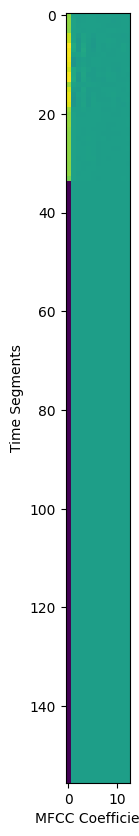

In [12]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10,10)

mfcc_data=x_test_mfcc[rand_idx,:,:,0].numpy()
fig, ax = plt.subplots()
ax.imshow(mfcc_data)
ax.set_xlabel("MFCC Coefficients")
ax.set_ylabel("Time Segments")
plt.show()

Here we define the hyperparameters for the CNN training and apply a scaling to the MFCC. 

In [13]:
batchSize = 10
epochs = 20
lr = 0.001

train_set = (x_train_mfcc/512 + 0.5)
train_labels = y_train

test_set = (x_test_mfcc/512 + 0.5)
test_labels = y_test

## CNN architecture
We are using a CNN to architecture to fuse information over multiple channels efficiently. Such an architecture has proven to be very effective in such a problem setting.

In [14]:
model = tf.keras.models.Sequential()

input_shape = (train_set.shape[1],train_set.shape[2],train_set.shape[3])
model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(filters=3,kernel_size=(3,3),padding="same", activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),strides=(2,2),padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2),padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=48,kernel_size=(3,3),padding='same',strides=(2,2), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(8, activation='relu'))

model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 156, 13, 3)        30        
                                                                 
 batch_normalization (Batch  (None, 156, 13, 3)        12        
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 7, 16)         448       
                                                                 
 batch_normalization_1 (Bat  (None, 78, 7, 16)         64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 3, 16)         0         
 D)                                                              
                                                      

Here we compile the model by defining the loss functions, the optimizer, and the metrics to be used. We then train the model.

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
model.fit(train_set, y_train, batchSize, epochs, validation_data=(test_set, y_test))

Epoch 1/20
100/100 [==============================] - 1s 9ms/step - loss: 0.4103 - accuracy: 0.8770 - val_loss: 0.8125 - val_accuracy: 0.2000
Epoch 2/20
100/100 [==============================] - 1s 8ms/step - loss: 0.1889 - accuracy: 0.9400 - val_loss: 0.8771 - val_accuracy: 0.2000
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 0.1368 - accuracy: 0.9520 - val_loss: 0.9329 - val_accuracy: 0.2000
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 0.1145 - accuracy: 0.9570 - val_loss: 1.8662 - val_accuracy: 0.2000
Epoch 5/20
100/100 [==============================] - 1s 8ms/step - loss: 0.1008 - accuracy: 0.9630 - val_loss: 0.6525 - val_accuracy: 0.6300
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 0.0804 - accuracy: 0.9710 - val_loss: 0.8169 - val_accuracy: 0.5700
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 0.0677 - accuracy: 0.9710 - val_loss: 1.9782 - val_accuracy: 0.8000
Epoch 

We evaluate the trained model on the remaining data.

In [16]:
score = model.evaluate(test_set, y_test, batch_size=batchSize)

10/10 [==============================] - 0s 3ms/step - loss: 2.9608 - accuracy: 0.8000


We can now save the model and deploy it using CubeAI.

In [17]:
model.save('MFCCmodel.h5')

/opt/anaconda3/envs/arm_lab/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
layer_1 = (
    240 * # kernel height
    240 * # kernel width
    3 * # number of input channels
    16 # number of output channels
)
layer_2 = (
    120 *
    120 *
    16 *
    32
)
layer_3 = (
    60 *
    60 *
    32 *
    64
)

layer_1 + layer_2 + layer_3

17510400

In [22]:
def count_params(W, K, P, S):
    return ((W - K + 2 * P) / S) + 1

In [24]:
layer_1 = count_params(240, 3, 0, 1)
layer_2 = count_params(120, 16, 0, 1)
layer_3 = count_params(60, 62, 0, 1)
layer_1 + layer_2 + layer_3

342.0